# Master thesis stuff

Import necessary packages and modules.

In [55]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt
import tensorflow as tf
import csv

import graph
from quantumGraphSolverFVM import QuantumGraphSolverFVM

Set up constants.

In [56]:
xth_frame = 5
# Time discretization of PINN
N_b = 200
# Time discretization of FVM
nt = N_b * xth_frame
# Spatial discretization of PINN
N_0 = 200
# Spatial discretization of FVM
nx = N_0 + 1

Generate Graph.

In [57]:
graph_test = graph.Example3()
graph_test.buildGraph()
graph_test.A

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]], dtype=int16)

Run FVM solver.

In [58]:
fvm_solver = QuantumGraphSolverFVM(graph_test)
u = fvm_solver.solve(nx=nx, nt=nt)
np.shape(u)

(401, 1000)

Tries to get discretization

In [59]:
def get_values(fvm, j=0, u=None, fig=None):
    X = np.linspace(0, fvm.L, fvm.nx).reshape((-1, 1))
    pos = fvm.graph.pos
    E = fvm.graph.E
    xy_list = [pos[e[0]] + X * (pos[e[1]] - pos[e[0]]) / fvm.L for e in E]
    
    if u is None:
        u = fvm.u

    values_list = []
    
    for i, e in enumerate(fvm.graph.E):
        uk = fvm.get_u_edge(u, i, j)
        values_list.append([xy_list[i][:, 0], xy_list[i][:, 1], uk])
        
    return values_list

Fails...

Define function for writing csv.

In [68]:
def write_csv(fvm, j=0):
        u = fvm.u
        
        xspace = tf.linspace(1, np.shape(u)[0], np.shape(u)[0])
        tspace = tf.linspace(1, np.shape(u)[1], np.shape(u)[1])
        T, X = tf.meshgrid(tspace, xspace)
        
        with open('FVM_results.csv', 'w', newline='') as f:
            thewriter = csv.writer(f)
            for i in range(np.shape(u)[0]):
                for j in range(np.shape(u)[1]):
                    thewriter.writerow([X[i,j].numpy(), T[i,j].numpy(), u[i,j]])
                    # the right input parameters are needed

Write csv.

In [ ]:
write_csv(fvm_solver)

Some plotting.

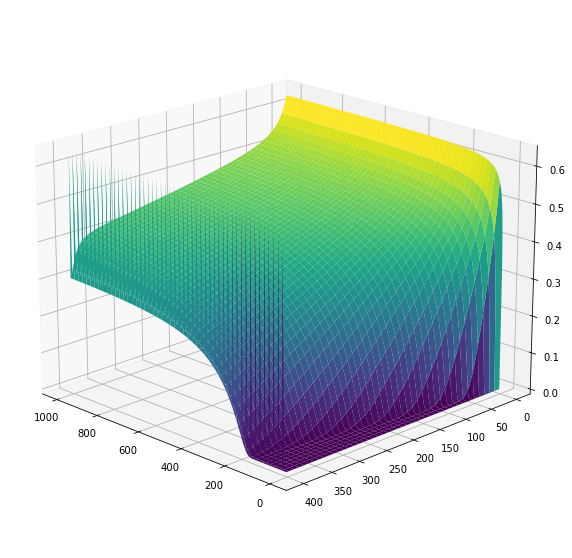

In [10]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

xspace = tf.linspace(1, 401, 401)
tspace = tf.linspace(1, 1000, 1000)
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = fvm_solver.u
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

<Axes3DSubplot:xlabel='$x$', ylabel='$y$'>

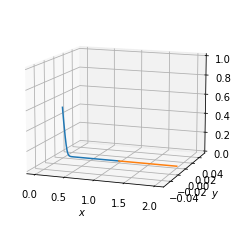

In [11]:
fvm_solver.plotNetwork(j=5)

# Approximating with FNN

Generate Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Dense

ffn = Sequential()
ffn.add(Dense(16, input_dim=2, activation='relu'))
ffn.add(Dense(16, activation='relu'))
ffn.add(Dense(1, activation='relu'))

ffn.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

Load Data.

In [13]:
dataset = np.loadtxt('FVM_results.csv', delimiter=',')
xt = dataset[:,0:2]
u = dataset[:,2]
xt.shape[0]

401000

Train Model.

In [14]:
ffn.fit(xt, u, epochs=3, batch_size=10)

Epoch 1/3
40100/40100 [==============================] - 27s 658us/step - loss: 1.7749 - accuracy: 0.0123s - loss: 1
Epoch 2/3
40100/40100 [==============================] - 30s 749us/step - loss: 0.1545 - accuracy: 0.0123
Epoch 3/3
40100/40100 [==============================] - 30s 746us/step - loss: 0.1581 - accuracy: 0.0123


Evaluate model.

In [15]:
accuracy = ffn.evaluate(xt, u)
print(accuracy)

12532/12532 [==============================] - 7s 512us/step - loss: 0.1545 - accuracy: 0.0123
[0.15453559160232544, 0.012254363857209682]


Plot results.

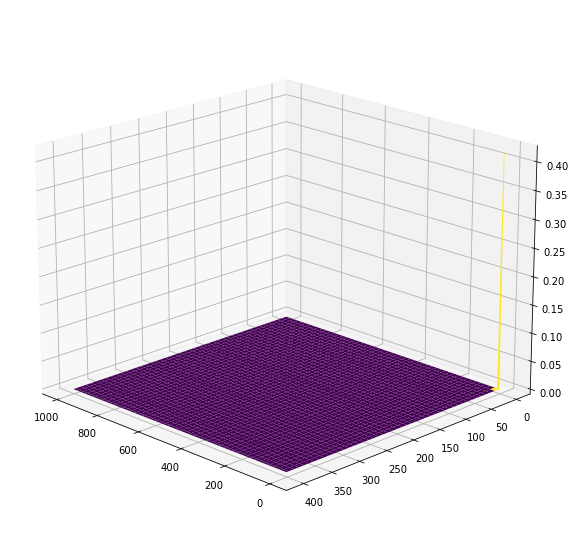

In [16]:
u_ffn = ffn(xt)

Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

xspace = tf.linspace(1, 401, 401)
tspace = tf.linspace(1, 1000, 1000)
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = u_ffn
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# Approximating with ResNet

Define Residual Network.

In [17]:
class ResNet(tf.keras.Model):

    def __init__(self,
                 ResNetLayers=1,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 **kwargs):
        
        super(ResNet, self).__init__(**kwargs)
        
        RNact = tf.keras.activations.get('relu')
        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = 2
        self.output_dim = 1

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi

Generate Residual network.

In [18]:
resnet = ResNet()
resnet.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam', metrics=['accuracy'])

Train network.

In [19]:
resnet.fit(xt, u, epochs=3, batch_size=10)

Epoch 1/3
40100/40100 [==============================] - 29s 707us/step - loss: 15504496.0000 - accuracy: 0.0081
Epoch 2/3
40100/40100 [==============================] - 31s 761us/step - loss: 518.8763 - accuracy: 0.0120
Epoch 3/3
40100/40100 [==============================] - 31s 771us/step - loss: 395.7398 - accuracy: 0.0098


Evaluate Network

In [20]:
accuracy = resnet.evaluate(xt, u)
print(accuracy)

12532/12532 [==============================] - 6s 491us/step - loss: 0.8377 - accuracy: 0.0121
[0.837730348110199, 0.012147132307291031]


In [21]:
u_resnet = resnet(xt)

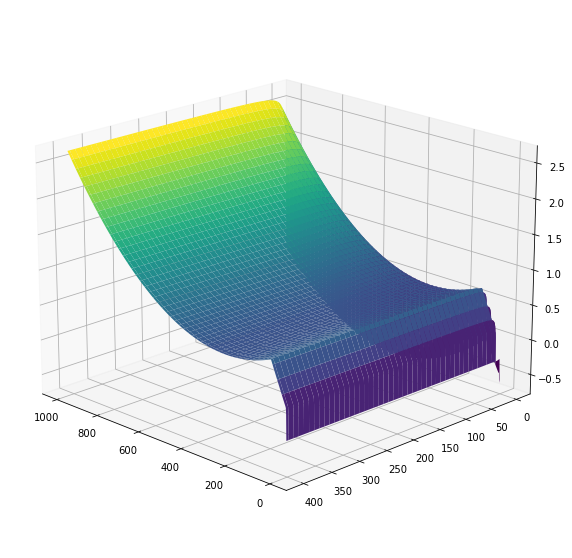

In [22]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

xspace = tf.linspace(1, 401, 401)
tspace = tf.linspace(1, 1000, 1000)
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = u_resnet
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)


# PINN for each edge

In [23]:
import networkx as nx

DTYPE='float64'

In [24]:
class PINN(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 output_dim=1,
                 num_hidden_layers=2,
                 num_neurons_per_layer=20,
                 activation= 'relu',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        
        super().__init__(**kwargs)

        self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = output_dim
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Inititialize num_hidden_layers many fully connected dense layers
        self.hidden = [tf.keras.layers.Dense(num_neurons_per_layer,
                                             activation=tf.keras.activations.get(
                                                 activation),
                                             kernel_initializer=kernel_initializer) for _ in range(self.num_hidden_layers)]
        
        # Output layer
        #self.out = tf.keras.layers.Dense(output_dim, activation=None)
        self.out = tf.keras.layers.Dense(output_dim, activation= 'relu')
        
    def call(self, X):
        """Forward-pass through neural network."""
        
        #Z = self.scale(X)
        Z = X
        
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
            
        return self.out(Z)

In [25]:
class GraphPINN():
    
    def __init__(self, A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        self.A = A
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij)

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))

In [26]:
gPINN = GraphPINN(graph_test.A, graph_test.dirichletNodes, graph_test.dirichletAlpha, graph_test.dirichletBeta, graph_test.lb, graph_test.ub)

Initialized 2 neural nets.


In [27]:
from time import time 

class graphPINNSolver(object):
    def __init__(self, graphPINN, data):
        
        self.graphPINN = graphPINN
        self.ne = self.graphPINN.ne
        
        self.output = tf.convert_to_tensor(data[:,2], dtype=DTYPE)
        
        self.xt = tf.convert_to_tensor(data[:,0:2], dtype=DTYPE)

        # Initialize history of losses and global iteration counter
        self.hist = []
        self.iter = 0
        
        # Call each network once to initialize trainable variables
        self.trainable_variables = []
        for i in range(self.ne):
            self.graphPINN.NNs[i](tf.constant([[1., 1.]], dtype=DTYPE))
            self.trainable_variables.append(self.graphPINN.NNs[i].trainable_variables)
        
        
        self.nvar = len(self.trainable_variables)

         
    def _fvals0(self, t, x):

        # Initialize lists for values and derivatives
        u = []
        tx = tf.stack([t, x], axis=1)
        for i in range(self.ne):
            u.append(self.graphPINN.NNs[i](tx)[:,0])

        return u
            
    
    def loss_fn(self):
        mse = lambda x : tf.reduce_mean(tf.square(x))
        
        u = self._fvals0(self.xt[:,1], self.xt[:,0])
        
        loss = mse(u - self.output)
        
        return loss
    
    @tf.function
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with
            # respect to trainable variables
            tape.watch(self.trainable_variables)
            loss = self.loss_fn()

        g = tape.gradient(loss, self.trainable_variables)
        del tape

        return loss, g
    
    
    def solve_with_TFoptimizer(self, optimizer, N=1001):
        """This method performs a gradient descent type optimization."""
        
        self.callback_init()
        
        for i in range(N):
            loss, g = self.get_grad()

            # Perform gradient descent step
            for j in range(self.nvar):
                optimizer.apply_gradients(zip(g[j], self.trainable_variables[j]))

            self.current_loss = loss.numpy()
            self.callback()
            
    def solve_with_ScipyOptimizer(self, method='L-BFGS-B', **kwargs):
        """This method provides an interface to solve the learning problem
        using a routine from scipy.optimize.minimize.
        (Tensorflow 1.xx had an interface implemented, which is not longer
        supported in Tensorflow 2.xx.)
        Type conversion is necessary since scipy-routines are written in
        Fortran which requires 64-bit floats instead of 32-bit floats."""

        def get_weight_tensor():
            """Function to return current variables of the model
            as 1d tensor as well as corresponding shapes as lists."""

            weight_list = []
            shape_list = []

            # Loop over all variables, i.e. weight matrices, bias vectors
            # and unknown parameters
            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    shape_list.append(v.shape)
                    weight_list.extend(v.numpy().flatten())

            weight_list = tf.convert_to_tensor(weight_list)
            return weight_list, shape_list


        x0, shape_list = get_weight_tensor()

        def set_weight_tensor(weight_list):
            """Function which sets list of weights
            to variables in the model."""
            idx = 0

            for i in range(len(self.trainable_variables)):
                for v in self.trainable_variables[i]:
                    vs = v.shape

                    # Weight matrices
                    if len(vs) == 2:
                        sw = vs[0] * vs[1]
                        new_val = tf.reshape(
                            weight_list[idx:idx + sw], (vs[0], vs[1]))
                        idx += sw

                    # Bias vectors
                    elif len(vs) == 1:
                        new_val = weight_list[idx:idx+vs[0]]
                        idx += vs[0]

                    # Variables (in case of parameter identification setting)
                    elif len(vs) == 0:
                        new_val = weight_list[idx]
                        idx += 1

                    # Assign variables (Casting necessary since scipy requires float64 type)
                    v.assign(tf.cast(new_val, DTYPE))

        def get_loss_and_grad(w):
            """Function that provides current loss and gradient
            w.r.t the trainable variables as vector. This is mandatory
            for the LBFGS minimizer from tfp.optimizer."""

            # Update weights in model
            set_weight_tensor(w)
            # Determine value of \phi and gradient w.r.t. \theta at w
            loss, grad = self.get_grad()
            # Flatten gradient
            grad_flat = []
            for i in range(len(self.trainable_variables)):
                for g in grad[i]:
                    grad_flat.extend(g.numpy().flatten())

            # Store current loss for callback function
            self.current_loss = loss

            # Return value and gradient of \phi as tuple
            return loss.numpy().astype(np.float64), np.array(grad_flat, dtype=np.float64)

        self.callback_init()

        return scipy.optimize.minimize(fun=get_loss_and_grad,
                                       x0=x0,
                                       jac=True,
                                       method=method,
                                       callback=self.callback,
                                       **kwargs)
    
    def callback_init(self):
        self.t0 = time()
        print(' Iter            Loss    Time')
        print('-----------------------------')
    
    def callback(self, xr=None):
        if self.iter % 20 == 0:
            print('{:05d}  {:10.8e}   {:4.2f}'.format(
                self.iter, self.current_loss, time() - self.t0))
        self.hist.append(self.current_loss)
        self.iter += 1
        
    def plot_loss_history(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

In [28]:
solver = graphPINNSolver(gPINN, dataset)
solver.graphPINN.NNs[0](tf.constant([[1., 1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02615299]], dtype=float32)>

In [29]:
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver.solve_with_TFoptimizer(optim, N=201)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
00000  5.88922285e+03   0.38
00020  1.54539777e-01   2.38
00040  1.54539777e-01   4.42
00060  1.54539777e-01   6.64
00080  1.54539777e-01   9.49
00100  1.54539777e-01   12.47
00120  1.54539777e-01   15.29
00140  1.54539777e-01   18.05
00160  1.54539777e-01   20.94
00180  1.54539777e-01   23.84
00200  1.54539777e-01   26.73


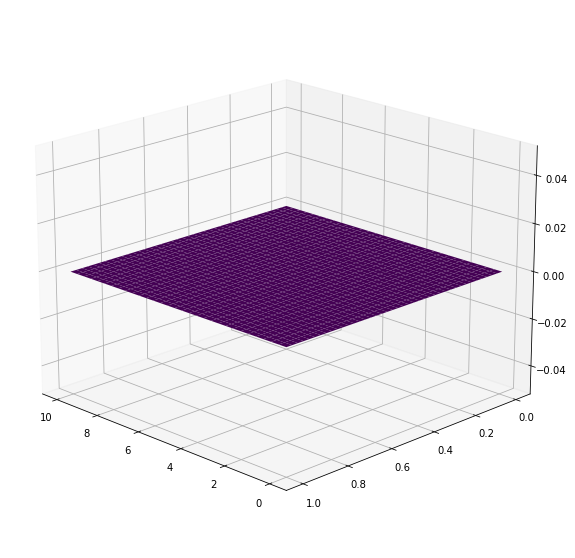

In [30]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

lb = graph_test.lb
ub = graph_test.ub

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# ResNet for each edge

In [31]:
class PINN_ResNet(tf.keras.Model):
    """ Set basic architecture of the PINN model."""

    def __init__(self, lb, ub,
                 ResNetLayers=1,
                 ResNetNeurons=16,
                 ResNetStepsize=1.0,
                 ResNetActivation='softplus',
                 **kwargs):
        
        super(PINN_ResNet, self).__init__(**kwargs)
        
        #RNact = tf.keras.activations.get(ResNetActivation)
        #RNact = my_act
        RNact = tf.keras.activations.get('relu')
        

        
        self.ResNetLayers = ResNetLayers
        self.ResNetStepsize = ResNetStepsize

        self.ResNet = [tf.keras.layers.Dense(ResNetNeurons,
                                        activation=RNact) for _ in range(self.ResNetLayers)]
        self.wb = tf.keras.layers.Dense(1)
        self.A = tf.keras.layers.Dense(2, use_bias=False)
        self.c = tf.keras.layers.Dense(1, use_bias=False)
        
        #self.num_hidden_layers = num_hidden_layers
        self.input_dim = lb.shape[0]
        self.output_dim = 1
        self.lb = lb
        self.ub = ub

        # Define NN architecture
        
        # Output layer
        #self.out = tf.keras.layers.Dense(1, activation='sigmoid')

        
    def call(self, input_tensor, training=False):
        """Forward-pass through neural network."""
        N = self.ResNet[0](input_tensor, training=training)
        for i in range(1, self.ResNetLayers):
            N = N + self.ResNetStepsize * self.ResNet[i](N, training=training)
        Phi = self.wb(N, training=training)
        #print(input_tensor)
        As = self.A(input_tensor, training=training)
        #print(As)
        sAs = tf.keras.layers.Dot(axes=(1))([input_tensor, As])
        #print(sAs)
        Phi += .5 * sAs
        #print(Phi.shape)
        Phi += self.c(input_tensor, training=training)
            
        return Phi
        #return self.out(Phi)

In [32]:
class GraphPINN_ResNet():
    
    def __init__(self, A, dirichletNodes, dirichletAlpha, dirichletBeta, lb, ub):
        
        self.A = A
        
        self.dirichletNodes = dirichletNodes
        self.dirichletAlpha = dirichletAlpha
        self.dirichletBeta = dirichletBeta
        
        self.lb = lb
        self.ub = ub
        
        # Get number of vertices
        self.n_v = self.A.shape[0]
        
        # Determine lists of edges and lengths
        self._determineEdgeList()
        
        # Determine list of vertices and incoming as well as outgoing edges
        self._determineVertexList()
        
        # Setup list of neural networks
        self._setupNNs()
        
        
    def _determineEdgeList(self):
        """Determine edge matrix and weight vector.
        This could also be accomplished by a loop over `G.edges`:
            for e in G.edges:
                print(e)
        """
        
        self.E = []
        self.W = []
        
        for i in range(self.n_v):
            for j in range(i + 1, self.n_v):
                aij = self.A[i, j]
                if aij > 0:
                    #print('Connectivity between i: {} and j: {}'.format(i,j))
                    self.E.append([i, j])
                    self.W.append(aij)

        # Get number of edges
        self.ne = len(self.E)
        
    def _determineVertexList(self):
        
        self.Vin = [[] for _ in range(self.n_v)]
        self.Vout = [[] for _ in range(self.n_v)]
        
        for i, e in enumerate(self.E):
            # Unpack edge
            vin, vout = e
            self.Vin[vout].append(i)
            self.Vout[vin].append(i)            
            
        self.innerVertices = np.setdiff1d(np.arange(self.n_v), self.dirichletNodes)
            
    def _setupNNs(self):
        
        self.NNs = []
        for i, e in enumerate(self.E):
            self.NNs.append(PINN_ResNet(lb=self.lb, ub=self.ub))
    
        print('Initialized {:d} neural nets.'.format(len(self.NNs)))

In [33]:
gPINN_ResNet = GraphPINN_ResNet(graph_test.A, graph_test.dirichletNodes, graph_test.dirichletAlpha, graph_test.dirichletBeta, graph_test.lb, graph_test.ub)

Initialized 2 neural nets.


In [34]:
solver_ResNet = graphPINNSolver(gPINN_ResNet, dataset)
solver_ResNet.graphPINN.NNs[0](tf.constant([[1., 1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.0956154]], dtype=float32)>

In [35]:
lr = 0.01
optim = tf.keras.optimizers.Adam(learning_rate=lr)
print('Start with TF optimizer\n')
solver_ResNet.solve_with_TFoptimizer(optim, N=2001)

Start with TF optimizer

 Iter            Loss    Time
-----------------------------
00000  1.90306047e+10   1.19
00020  1.02940412e+10   2.72
00040  4.06000671e+09   4.29
00060  1.11321491e+09   6.11
00080  1.93329392e+08   8.43
00100  1.83142962e+07   10.59
00120  3.06753454e+06   12.75
00140  3.03299743e+06   14.95
00160  2.74175072e+06   17.16
00180  2.51430831e+06   19.27
00200  2.28445745e+06   21.44
00220  2.05846053e+06   23.76
00240  1.83946307e+06   25.94
00260  1.63180298e+06   28.05
00280  1.43796334e+06   30.20
00300  1.25959410e+06   32.33
00320  1.09706414e+06   34.47
00340  9.50261544e+05   36.62
00360  8.18743322e+05   38.96
00380  7.01811516e+05   41.15
00400  5.98586621e+05   43.29
00420  5.08072664e+05   45.46
00440  4.29209064e+05   47.56
00460  3.60913753e+05   49.70
00480  3.02115969e+05   51.82
00500  2.51780445e+05   53.96
00520  2.08924329e+05   56.24
00540  1.72629935e+05   58.43
00560  1.42051568e+05   60.56
00580  1.16419224e+05   62.67
00600  9.50387821e+0

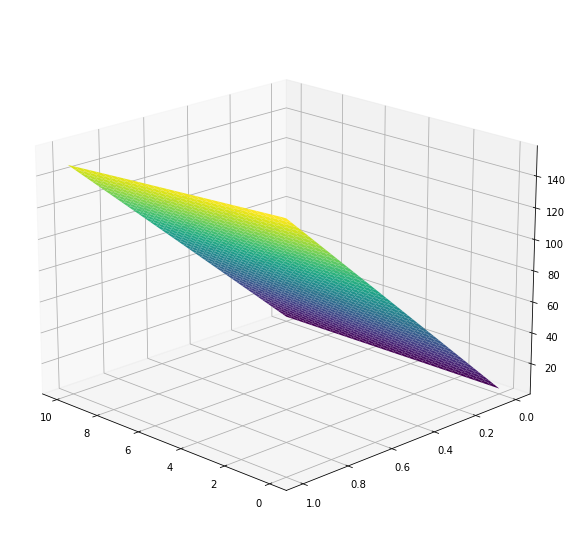

In [36]:
Eidx = 0

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
Nt = 60
Nx = 120

lb = graph_test.lb
ub = graph_test.ub

tspace = tf.linspace(lb[0], ub[0], Nt + 1)
xspace = tf.reshape(tf.linspace(lb[1], ub[1], Nx + 1), [-1, 1])
T, X = tf.meshgrid(tspace, xspace)
TX=tf.stack([tf.reshape(T,-1), tf.reshape(X,-1)],axis=1)
U = solver_ResNet.graphPINN.NNs[Eidx](TX) #-  solver.graphPINN.NNs[1](TX)
U = tf.reshape(U, T.shape)
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(19, 135)

# Stuff

In [ ]:
import tensorflow as tf

In [ ]:
mse = lambda x : tf.reduce_mean(tf.square(x))

In [ ]:
x = tf.Variable([5.])

In [ ]:
tmin = 0.
tmax = 10.
xmin = 0.
xmax = 1.

In [ ]:
lb = np.array([tmin, xmin])

# Upper bounds
ub = np.array([tmax, xmax])

In [ ]:
X_r = tf.random.uniform((4000,2), lb, ub, dtype='float64')

In [2]:
xspace = tf.linspace(1, 401, 401)
tspace = tf.linspace(1, 1000, 1000)
T, X = tf.meshgrid(tspace, xspace)

NameError: name 'tf' is not defined

In [1]:
T[89,90].numpy()

NameError: name 'T' is not defined